# Лабораторная работа №1.1 "Экспериментальная проверка уравнения Эйнштейна для фотоэффекта и определение постоянной Планка"

В работе исследуется зависимость фототока от величины задерживающего потенциала и частоты падающего излучения, что позволяет вычислить величину постоянной Планка.

Уравнение Эйнштейна:
\begin{equation}
\label{eq1}
\hbar \omega = E_{\text{max}} + W
\end{equation}
где $E_{\text{max}}$ - максимальная кинетическая энергия электрона после выхода из фотокатода, $W$ - работа выхода электрона из катода.

Из описания имеем формулу для полного числа частиц:
\begin{equation}
\label{eq2}
N(\nu) = 2\pi n_0 \left[ \dfrac{\nu_0^2}{4} - \left(\dfrac{1 - V/V_0}{\nu_0} - \dfrac{\nu_0}{2}\right)^2 \right]
\end{equation}
Корень квадратный из фототока линейно зависит от запирающего напряжения.

### Калибровочный график

In [73]:
import pandas as pd

CALIBRATION_DATA_PATH = './calibration.csv'
LAMP_DATA_PATH = './all_data.csv'
df_calibration = pd.read_csv(CALIBRATION_DATA_PATH, sep=';', dtype=float)
df_calibration.head()

,lambda,angle
0,5341.0,1830.0
1,5401.0,1878.0
2,5852.0,2140.0
3,5882.0,2150.0
4,5945.0,2180.0


Посмотрим, является ли калибровочный график прямой

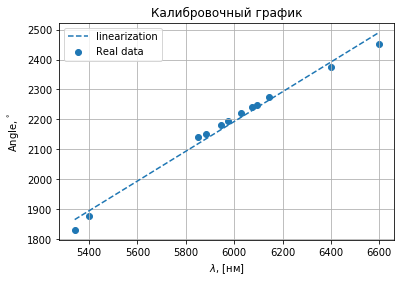

In [74]:
import matplotlib.pyplot as plt

x, y = df_calibration['lambda'], df_calibration['angle']
plt.scatter(df_calibration['lambda'], df_calibration['angle'], label='Real data')

# Аппроксимация
from scipy.stats import linregress
calibration_slope, calibration_intercept, r_value, p_value, std_err = linregress(x,y)
plt.plot(x, calibration_slope*x+calibration_intercept, '--', label='linearization')

plt.xlabel('$\lambda$, [нм]')
plt.ylabel('Angle, $^\degree$')
plt.grid()
plt.legend()
plt.title(r'Калибровочный график')

plt.show()

Видно, что в середине диапазона калибровочной график хорошо описывается прямой. Это нам пригодится в будущем, а пока сделаем функцию для перевода угла в длину волны

In [75]:
angle_to_lambda = lambda angle: calibration_slope*angle + calibration_intercept

### Информация с лампы

In [76]:
df_lamp = pd.read_csv(LAMP_DATA_PATH, sep=';', dtype=float)
df_lamp.head()

,angle,V,I
0,1850.0,5.440,0.517
1,1850.0,4.910,0.508
2,1850.0,4.412,0.501
3,1850.0,3.915,0.491
4,1850.0,3.409,0.478


In [84]:
angles = pd.unique(df_lamp['angle'])

На самом деле, в столбце $I$ находится не сам $I$, а напряжение, пропорциональное $I$. Но для нас это не важно, так как в этой работе мы интересуемся только напряжением запирания. **Поэтому будем дальше писать $I$ вместо $U$.**

Из уравнения выше следует, что нам надо строить график зависимости $V = V(\sqrt{I})$.

#### Угол $1850˚$

In [90]:
import numpy as np


def handle_angle(angle, fig=None, axes=None):
    
    if fig is None or axes is None:
        fig, axes = plt.subplots(figsize=(16, 9))

    subset = df_lamp[df_lamp['angle'] == angle]

    x, y = subset['I'], np.sqrt(subset['V'])
    axes.scatter(x, y, label='experiment')

    axes.set_xlabel(r'$\sqrt{I}$')
    axes.set_ylabel(r'$V$')
    
    return fig, axes

/Users/aleksei/.virtualenvs/math/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


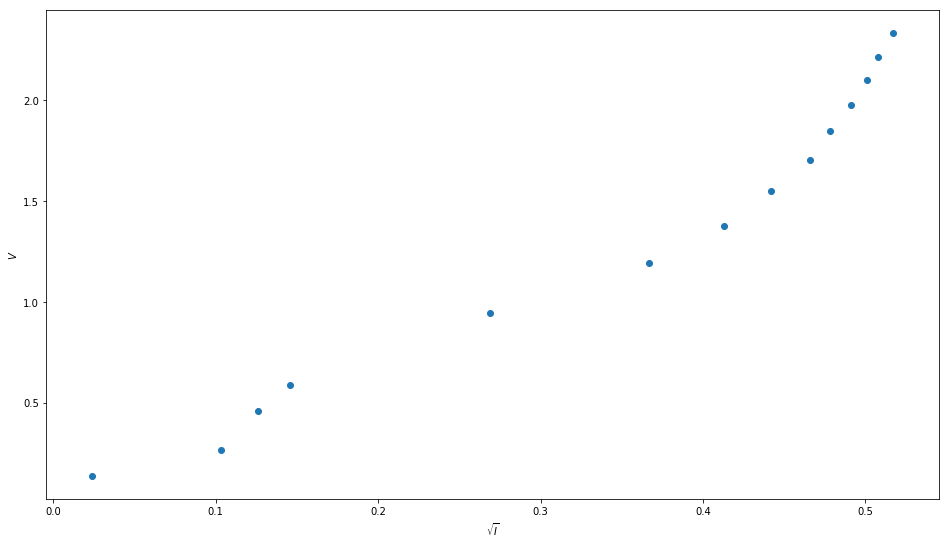

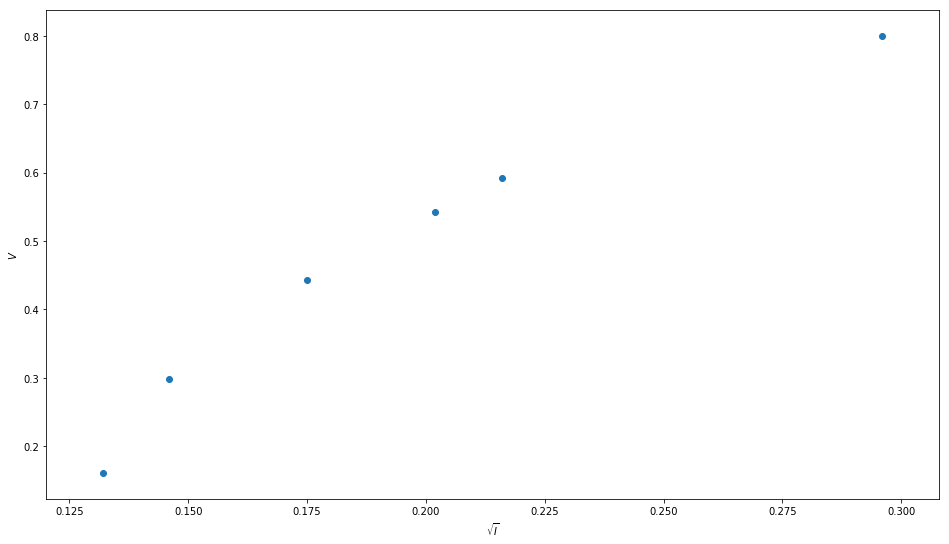

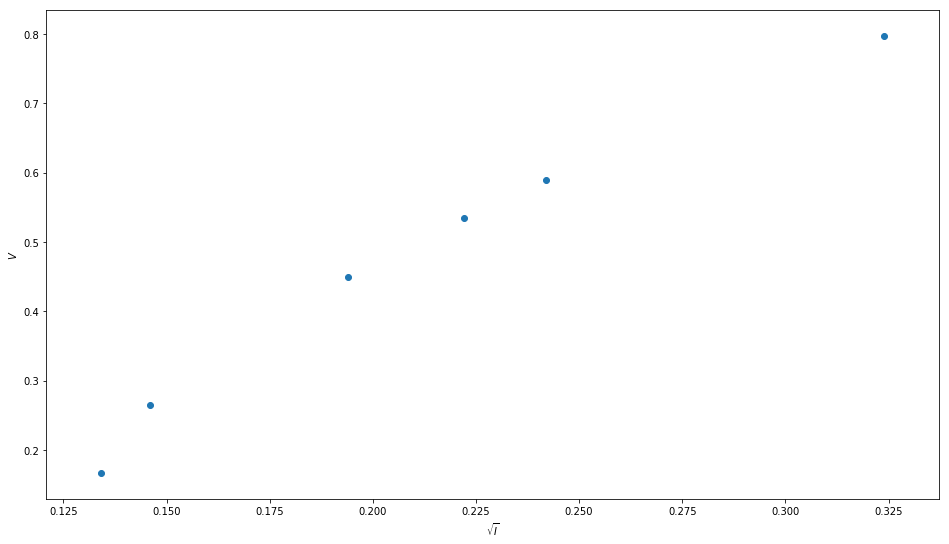

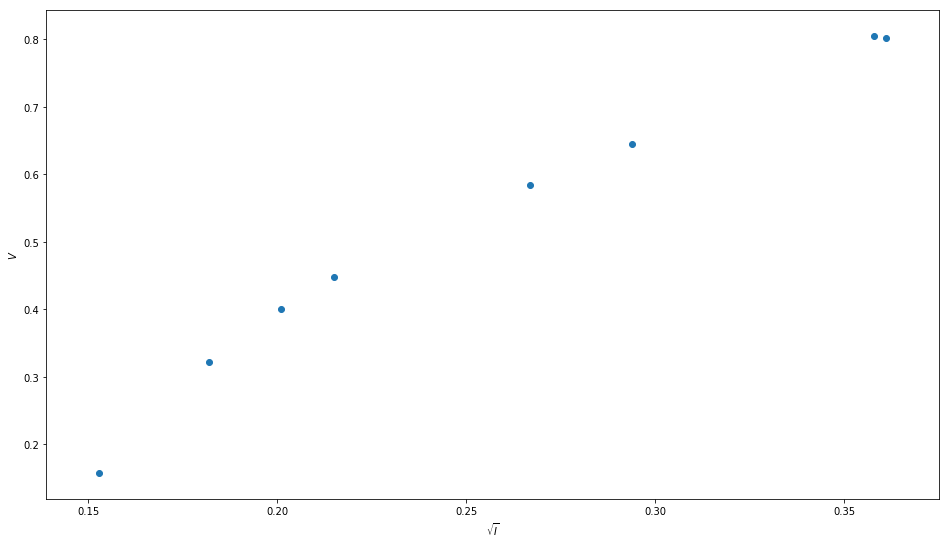

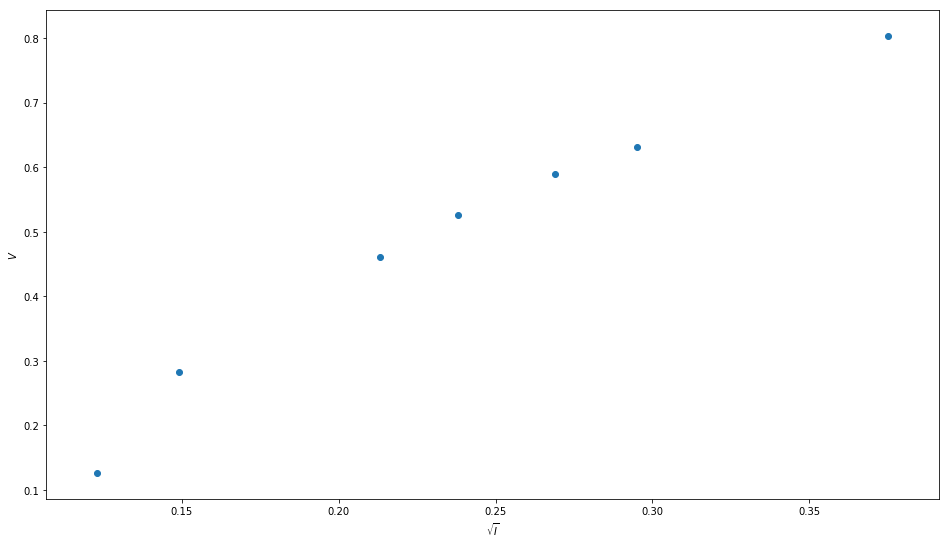

In [91]:
#fig, axes = plt.subplots(figsize=(16, 9))
for angle in angles:
    handle_angle(angle)